
=== Hot PMV +3, Needs Cooling ===

PMV ≈ 0 reached in 4 min (0.07 hrs)
Energy saved: 0.13 kWh
Carbon saved: 0.04 kg CO₂
Cost saved: $0.02
Energy Saved: 0.13 kWh
Carbon Saved: 0.04 kg CO₂
Cost Saved: $0.02


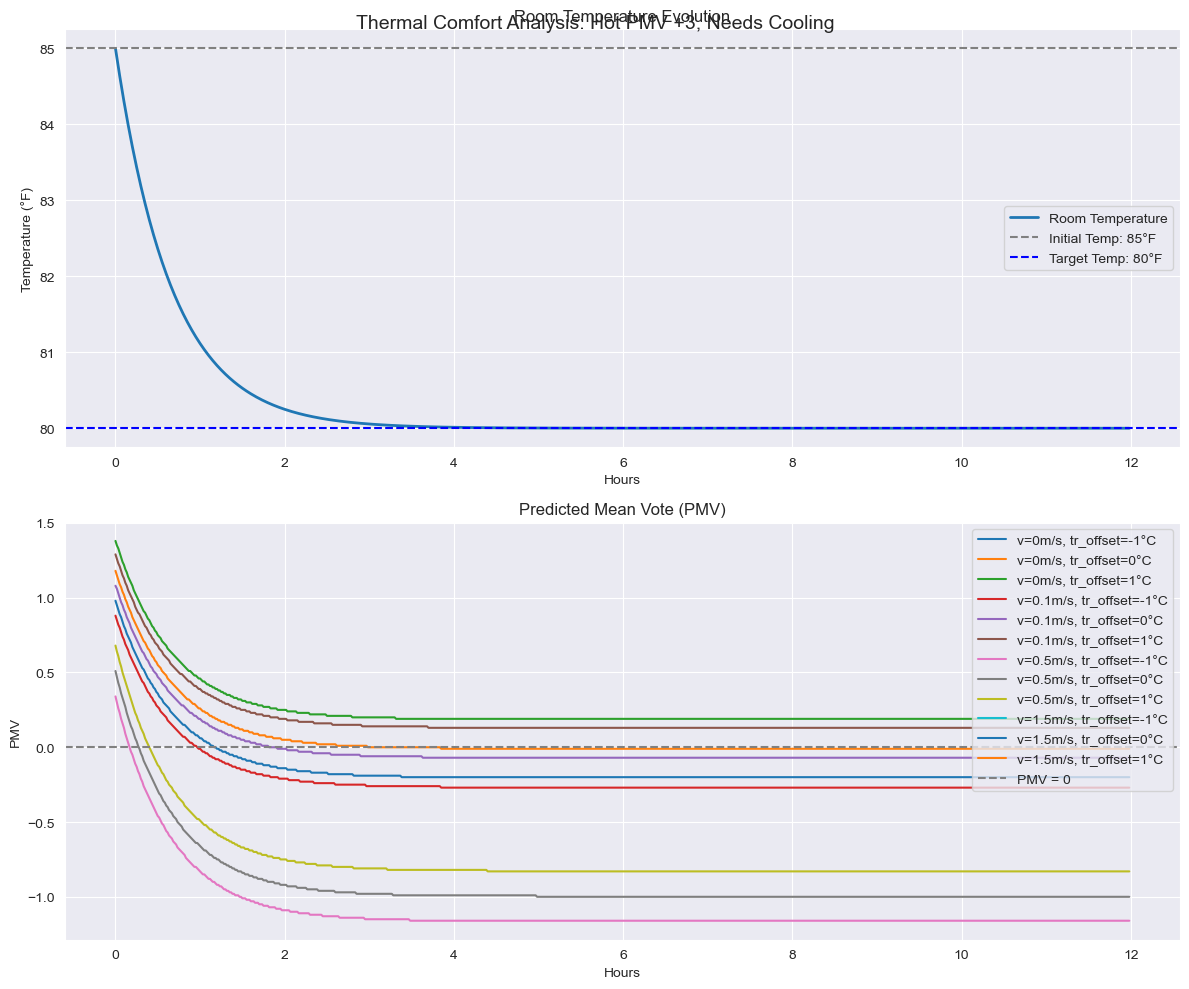


=== Cold PMV -2, Needs Heating ===

Comfort not reached within 12.0 hours.
Energy Saved: 0.0 kWh
Carbon Saved: 0.0 kg CO₂
Cost Saved: $0.0


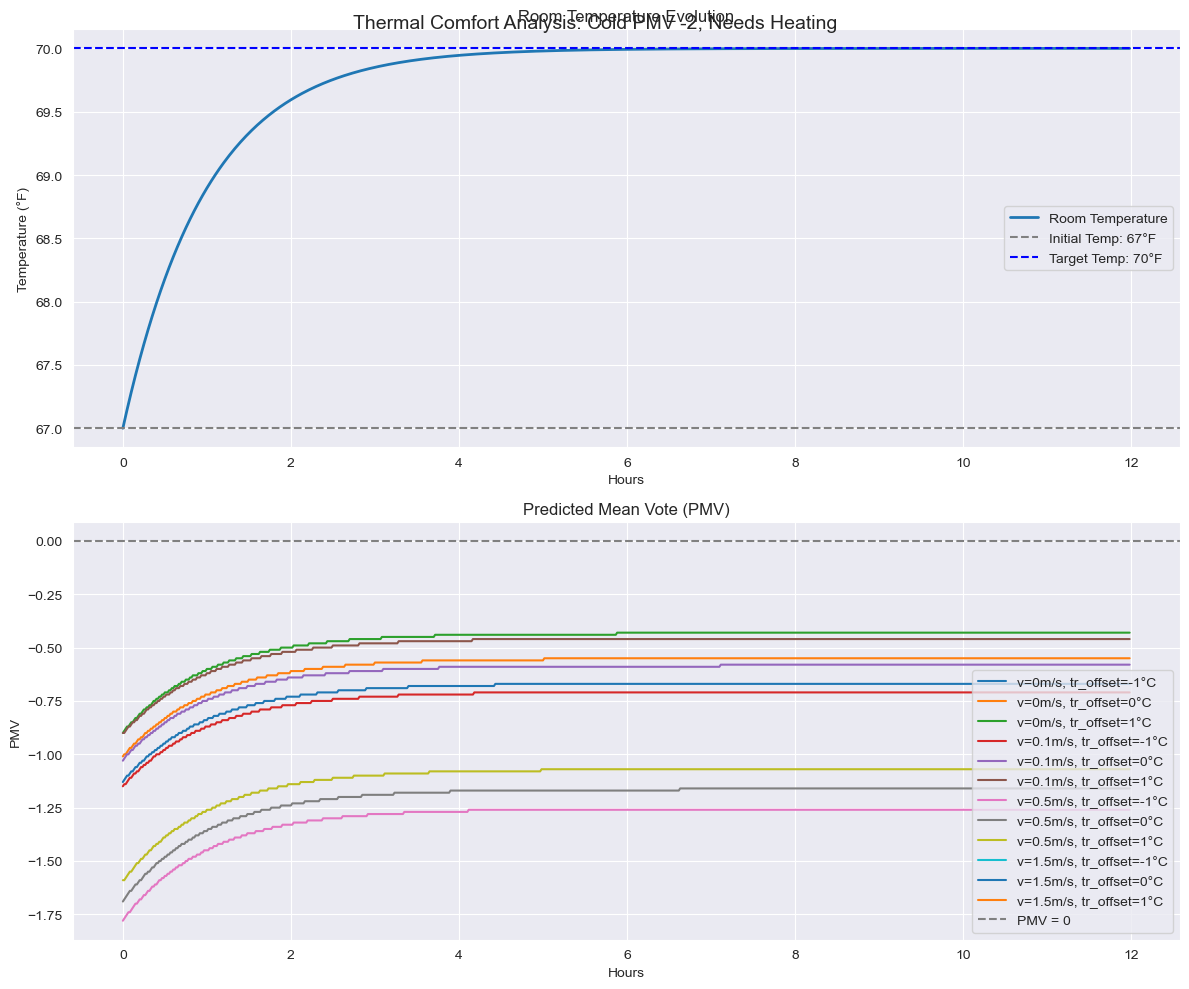

In [2]:
import numpy as np
from pythermalcomfort.models import pmv_ppd_iso
import matplotlib.pyplot as plt

def simulate_thermal_comfort(
    T_outdoor=80,
    T_room_initial=80,
    tau=60,
    rh=50,
    met=1.0,
    clo=None,
    wind_speeds=[0, 0.1, 0.5, 1.5],  # m/s,         # air speeds
    radiant_offsets=[-1, 0, 1],       # radiant offsets in °C
    initial_pmv=2.0,
    season=None,
    total_minutes=720,
    device="fan",
    baseline="AC",
    city="default"
):
    # --- CLO setup based on season ---
    if clo is None:
        if season == 'summer':
            clo = 0.36
        elif season == 'winter':
            clo = 1.0
        else:
            clo = 0.5

    # --- PMV-based temperature target ---
    if initial_pmv >= 2:
        delta = -5 if initial_pmv >= 3 else -3
    elif initial_pmv <= -2:
        delta = +5 if initial_pmv <= -3 else +3
    else:
        delta = 0

    T_target_F = T_room_initial + delta
    T_target_C = (T_target_F - 32) * 5/9
    T_room_initial_C = (T_room_initial - 32) * 5/9

    # --- Time & result storage ---
    minutes = np.arange(0, total_minutes, 1)
    results = {}
    time_to_comfort = None
    temp_curves = {}

    for v in wind_speeds:
        for tr_offset in radiant_offsets:
            temps = T_target_C + (T_room_initial_C - T_target_C) * np.exp(-minutes / tau)

            if v == wind_speeds[0] and tr_offset == radiant_offsets[0]:
                temp_curves["Room Temperature"] = [(t * 9/5) + 32 for t in temps]

            pmvs = []
            for ta in temps:
                tr = ta + tr_offset
                pmv_result = pmv_ppd_iso(tdb=ta, tr=tr, vr=v, rh=rh, met=met, clo=clo)
                pmvs.append(pmv_result['pmv'])

            key = f"v={v}m/s, tr_offset={tr_offset}°C"
            results[key] = pmvs

            for i, pmv in enumerate(pmvs):
                if -0.2 <= pmv <= 0.2:
                    if time_to_comfort is None or i < time_to_comfort:
                        time_to_comfort = i
                    break

    # --- Calculate Energy, CO2, Cost ---
    power_kW = {
        "AC": 2.0,
        "window_AC": 1.0,
        "fan": 0.06,
        "heater": 1.0,
        "space_heater": 1.5,
        "dehumidifier": 0.3,
        "window": 0.0,
        "none": 0.0
    }

    emissions_kg_per_kWh = {
        "pittsburgh": 0.331,
        "new york": 0.202,
        "seattle": 0.259,
        "default": 0.33
    }

    cost_per_kWh = 0.17
    hours = (time_to_comfort or 0) / 60

    power_baseline = power_kW.get(baseline, 0)
    power_action = power_kW.get(device, 0)
    energy_diff = (power_baseline - power_action) * hours
    emission_factor = emissions_kg_per_kWh.get(city.lower(), emissions_kg_per_kWh["default"])

    carbon_kg = energy_diff * emission_factor
    cost_usd = energy_diff * cost_per_kWh

    # --- Print Summary ---
    if time_to_comfort is not None:
        print(f"\nPMV ≈ 0 reached in {time_to_comfort} min ({hours:.2f} hrs)")
        print(f"Energy saved: {energy_diff:.2f} kWh")
        print(f"Carbon saved: {carbon_kg:.2f} kg CO₂")
        print(f"Cost saved: ${cost_usd:.2f}")
    else:
        print(f"\nComfort not reached within {total_minutes / 60} hours.")

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(minutes/60, temp_curves["Room Temperature"], label="Room Temperature", linewidth=2)
    ax1.axhline(T_room_initial, color='gray', linestyle='--', label=f'Initial Temp: {T_room_initial}°F')
    ax1.axhline(T_target_F, color='blue', linestyle='--', label=f'Target Temp: {T_target_F}°F')
    ax1.set_xlabel('Hours')
    ax1.set_ylabel('Temperature (°F)')
    ax1.set_title('Room Temperature Evolution')
    ax1.legend()
    ax1.grid(True)

    for label, pmvs in results.items():
        ax2.plot(minutes/60, pmvs, label=label)
    ax2.axhline(0, color='gray', linestyle='--', label='PMV = 0')
    ax2.set_xlabel('Hours')
    ax2.set_ylabel('PMV')
    ax2.set_title('Predicted Mean Vote (PMV)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    return {
        "fig": fig,
        "time_minutes": time_to_comfort,
        "energy_kWh": round(energy_diff, 2),
        "carbon_kg": round(carbon_kg, 2),
        "cost_usd": round(cost_usd, 2)
    }
# === Example Usage ===
def run_simulations():
    scenarios = [
        {
            "name": "Hot PMV +3, Needs Cooling",
            "params": {
                "T_outdoor": 90,
                "T_room_initial": 85,
                "tau": 40,
                "initial_pmv": 3.0,
                "season": "summer",
                "device": "fan",          # cooling action
                "baseline": "AC",         # baseline without energy-saving action
                "city": "pittsburgh"
            }
        },
        {
            "name": "Cold PMV -2, Needs Heating",
            "params": {
                "T_outdoor": 35,
                "T_room_initial": 67,
                "tau": 60,
                "initial_pmv": -2.0,
                "season": "winter",
                "device": "heater",       # heating action
                "baseline": "space_heater",  # baseline could be a less efficient option
                "city": "new york"
            }
        }
    ]

    for scenario in scenarios:
        print(f"\n=== {scenario['name']} ===")
        result = simulate_thermal_comfort(**scenario["params"])
        print(f"Energy Saved: {result['energy_kWh']} kWh")
        print(f"Carbon Saved: {result['carbon_kg']} kg CO₂")
        print(f"Cost Saved: ${result['cost_usd']}")
        result["fig"].suptitle(f"Thermal Comfort Analysis: {scenario['name']}", fontsize=14)
        plt.show()

if __name__ == "__main__":
    run_simulations()